In [1]:
pwd

'/home/roman/CODE/TFC/experiments/exp2'

# 🔥Experiment 2: Cross-subject transfer
## finetune on all subjects but the test, test on the test one

## Highlights|

- `targetDsName = 'BNCI001-2014.pt'`
- `pretrain_dataset`: all datasets but the `targetDsName`
- `finetune_dataset`: all except one held-out subject from the `target_dataset`
- `test_dataset`: the held-out subject


### plot the mean and std for eval losses of the 3 scenarios:

- train the classifier attached to a **pre-trained but frozen** feature detector
- co-train the classifier attached to a **pre-trained but not frozen** feature detector
- train the classifier and feature detector **from scratch** (i.e. same as training EEGNet from scratch)

- all the 3 scenarios are run in `EEGNet Contrastive Pretraining.ipynb`
- the curves below show the mean (over the subjects, and runs, 3 for each subject) test accuracy in the 3 scenarios

In [2]:
# Get all the runs for a particular project:

import matplotlib.pyplot as plt
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("nightdude/EXP2 - Cross-subject transfer")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

In [3]:
df = []
for run in runs:
    _df = run.history()[['eval_acc', 'ep', 'train_acc', 'feat_loss', 'class_loss']]
    _df['name'] = run.name
    _df['name'] = run.group
    df += _df.to_dict(orient='records')
df = pd.DataFrame(df)

In [4]:
df['trained'] = df.name.apply(lambda x: x.split('_')[0])
df['frozen'] = df.name.apply(lambda x: x.split('_')[1])
df['ds'] = df.name.apply(lambda x: x.split('_')[3])
df['subj'] = df.name.apply(lambda x: x.split('_')[4])
df.drop(columns='name', inplace=True)

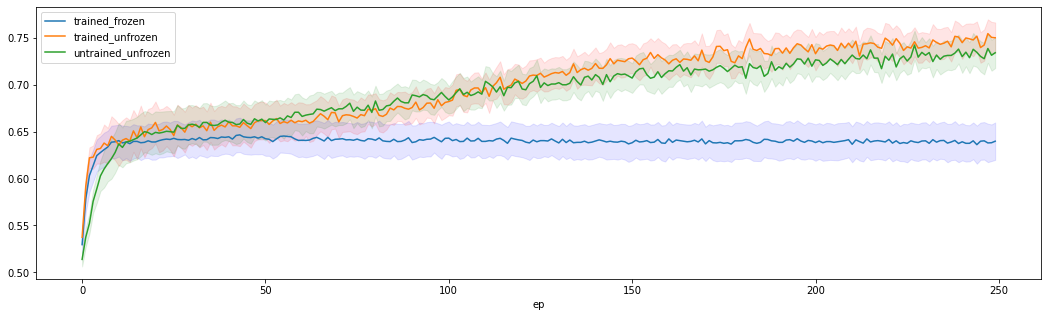

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
__df = df[(df.trained == 'trained') & (df.frozen == 'frozen')]
tmp = __df.groupby('ep').mean()
tmp['std'] = df[df.trained == 'trained'].groupby('ep').std().eval_acc / 5
tmp['std_'] = tmp.eval_acc + tmp['std']
tmp['_std'] = tmp.eval_acc - tmp['std']
tmp.plot(y='eval_acc', ax=ax, label = 'trained_frozen')
ax.fill_between(tmp.index.tolist(), tmp.std_.tolist(), tmp._std.tolist(), color='blue', alpha=0.1)

__df = df[(df.trained == 'trained') & (df.frozen == 'unfrozen')]
tmp = __df.groupby('ep').mean()
tmp['std'] = df[df.trained == 'untrained'].groupby('ep').std().eval_acc  / 5
tmp['std_'] = tmp.eval_acc + tmp['std']
tmp['_std'] = tmp.eval_acc - tmp['std']
tmp.plot(y='eval_acc', ax=ax, label = 'trained_unfrozen')
ax.fill_between(tmp.index.tolist(), tmp.std_.tolist(), tmp._std.tolist(), color='red', alpha=0.1)

__df = df[(df.trained == 'untrained') & (df.frozen == 'unfrozen')]
tmp = __df.groupby('ep').mean()
tmp['std'] = df[df.trained == 'untrained'].groupby('ep').std().eval_acc  / 5
tmp['std_'] = tmp.eval_acc + tmp['std']
tmp['_std'] = tmp.eval_acc - tmp['std']
tmp.plot(y='eval_acc', ax=ax, label = 'untrained_unfrozen')
ax.fill_between(tmp.index.tolist(), tmp.std_.tolist(), tmp._std.tolist(), color='green', alpha=0.1)
plt.savefig('Exp2.png')